In [7]:
#!/usr/bin/env 
# coding: utf-8

# This is python code written for use with PlantCV version 3.14.0
# This will find 3 possible plants from images taken using the RGB imaging
# platform in the Hirsch Lab at the University of Minnesota
# The script will output morphological and color traits fore each plant
# along with 3 images showing the masks of each plant found

# Cory D. Hirsch and Kevin Propst
# February 20, 2021 - orginal
# March 9, 2021 - fixes to left plant mask
# March 18, 2021 - fixes to left and middle plant mask
# March 24, 2021 - changes to pipeline to work with images from Hirsch lab imaging station -> change y values, roi, and cutting apart input file names


# Import Libraries
import argparse
import os
import cv2
import sys
import numpy as np
from matplotlib import pyplot as plt
from plantcv import plantcv as pcv
from plantcv import morphology

from plantcv.plantcv import params
from skimage import exposure, img_as_float
 

ImportError: cannot import name 'morphology' from 'plantcv' (/Users/propst/opt/anaconda3/lib/python3.8/site-packages/plantcv/__init__.py)

In [2]:
#Will display version of plantcv you are working with.
#Copy and paste into shell until you figure out how to run on here.

#pip show plantcv

In [2]:
# Set global debug behavior to None (default), "print" (to file), or "plot" (Jupyter Notebooks or X11)
# this makes lots of intermediate image files print out so you can see all the steps along the way
# comment out when not debugging
# will see this throughout as it was used in jupyter notebook for debugging and needed to be in each code cell
pcv.params.debug = "plot"

# #Define functions
# def options():
#     parser = argparse.ArgumentParser(description="Imaging processing with PlantCV.")
#     parser.add_argument("-d", "--image", help="Input image file.", required=True)
#     parser.add_argument("-r","--result", help="Result file.", required=False)
#     parser.add_argument("-p", "--pdfs", help="Naive Bayes PDF file.", required=True)
#     parser.add_argument("-o", "--outdir", help="Output directory for image files.", required=False)
#     parser.add_argument("-w","--writeimg", help="Write out images.", default=False, action="store_true")
#     parser.add_argument("-D", "--debug", help="Turn on debug, prints intermediate images.", action=None)
#     args = parser.parse_args()
#     return args

In [3]:
###
#Uncomment this section if testing with individual image hardcoded in
class options:
     def __init__(self):
        #self.image = "/Users/chirsch/Documents/projects/Maize/phenotyping/plantCV/cold_stress/{Plot_3816}{Experiment_107}{Genotype_B73}{Treatment_Control}{Day_10}.tiff"
        self.image= "/Users/propst/Desktop/kp_maize_project_folders/project_folder/H13/H13_nef/05-Dec-2022/{Plot_283}{Experiment_H13}{Planted_11-28-2022}{SeedSource_SP20_20590}{SeedYear_20}{Genotype_Ki11}{Treatment_control}{PictureDay_13}.tiff"
        self.debug = "print"
        self.writeimg = False
        self.result = "/Users/propst/Documents/output/results.txt"
        self.outdir = "/Users/propst/Documents/output"

args = options()
pcv.params.outdir = args.outdir
pcv.params.debug = args.debug
####

In [4]:
#def main():
#     args = options()
#     os.chdir(args.outdir)

# Read Image
# Read RGB image
img, path, filename = pcv.readimage(filename="/Users/propst/Desktop/kp_maize_project_folders/project_folder/H13/H13_nef/05-Dec-2022/{Plot_283}{Experiment_H13}{Planted_11-28-2022}{SeedSource_SP20_20590}{SeedYear_20}{Genotype_Ki11}{Treatment_control}{PictureDay_13}.tiff")
# Print what file pipeline is currently working on
print(filename)
print("boop")

####
# Get Metadata from file name for information about image taken
# Get genotype
geno_name = filename.split("}{")
print(geno_name)
print()
geno_name = geno_name[5]
geno_name = geno_name.split("_")
geno_name = geno_name[1]
print(geno_name)

    # Get day
day = filename.split("}{")
day = day[7]
day = day.split("_")
day= day[1]
day = day.split("}")
day = day[0]
print(day)

    # Get plot
plot = filename.split("}{")
plot = plot[0]
plot = plot.split("_")
plot = plot[1]
print(plot)

    # Get experiment number
exp_name = filename.split("}{")
exp_name = exp_name[1]
exp_name = exp_name.split("_")
exp_name = exp_name[1]
print(exp_name)

    # Get treatment conditions
treat_name = filename.split("}{")
treat_name = treat_name[6]
treat_name = treat_name.split("_")
treat_name = treat_name[1]
print(treat_name)

{Plot_283}{Experiment_H13}{Planted_11-28-2022}{SeedSource_SP20_20590}{SeedYear_20}{Genotype_Ki11}{Treatment_control}{PictureDay_13}.tiff
boop
['{Plot_283', 'Experiment_H13', 'Planted_11-28-2022', 'SeedSource_SP20_20590', 'SeedYear_20', 'Genotype_Ki11', 'Treatment_control', 'PictureDay_13}.tiff']

Ki11
13
283
H13
control


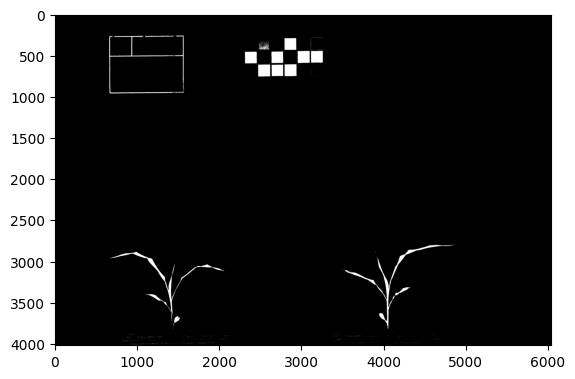

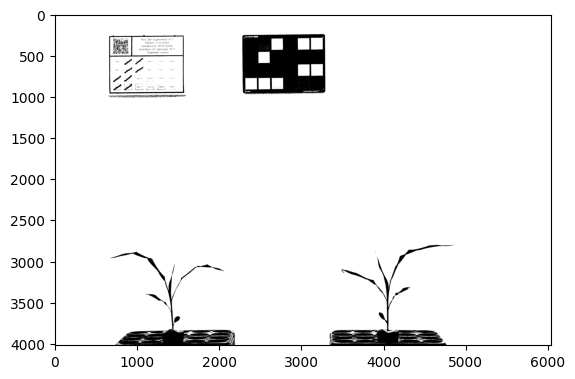

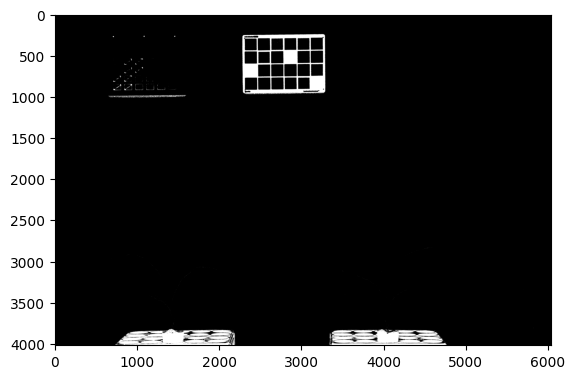

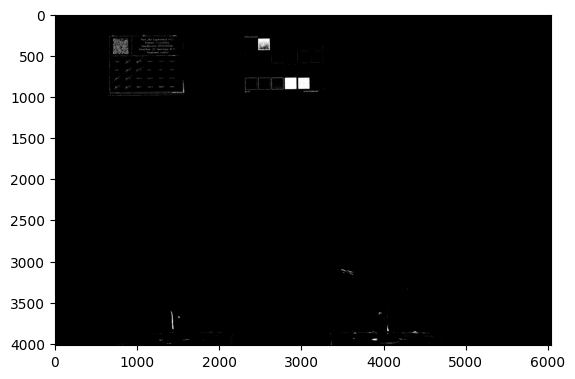

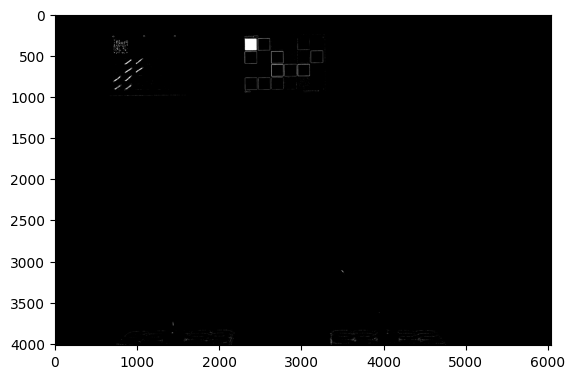

In [4]:
# Create masks using Naive Bayes Classifier and PDFS file
pcv.params.debug = "plot"

masks = pcv.naive_bayes_classifier(img,"/Users/propst/Desktop/kp_maize_project_folders/project_folder/pdfs.txt")


In [6]:
# # Create masks using Naive Bayes Classifier and PDFS file
# #pcv.params.debug = "plot"
# masks = pcv.naive_bayes_classifier(img,"/Users/propst/Desktop/project_folder/pdfs.txt")


In [5]:
import cv2
import plantcv as pcv
import numpy as np

# Load the image correctly
img = cv2.imread("/Users/propst/Desktop/kp_maize_project_folders/project_folder/H13/H13_nef/05-Dec-2022/{Plot_283}{Experiment_H13}{Planted_11-28-2022}{SeedSource_SP20_20590}{SeedYear_20}{Genotype_Ki11}{Treatment_control}{PictureDay_13}.tiff")

# Convert the RGB image to HSV and extract the Value (V) channel
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
v = hsv_img[:, :, 2]

# Threshold the Value image using OpenCV as PlantCV does not support this in newer versions
ret, v_thresh = cv2.threshold(v, 150, 255, cv2.THRESH_BINARY)

# Dilate the mask to fill holes using OpenCV
kernel = np.ones((5,5),np.uint8)  # A 5x5 kernel for dilation
dilate_racks = cv2.dilate(v_thresh, kernel, iterations=1)

# Fill in small objects using PlantCV's fill function
fill_racks = pcv.fill(dilate_racks, size=10)

# Use PlantCV's find_objects to detect objects
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=fill_racks)

# Apply edge detection using OpenCV
edges = cv2.Canny(fill_racks, 60, 180)

# Write all the straight lines from edge detection using Hough Transform
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=150, minLineLength=50, maxLineGap=15)

# Process the lines
if lines is not None:
    N = lines.shape[0]
    for i in range(N):
        x1 = lines[i][0][0]
        y1 = lines[i][0][1]
        x2 = lines[i][0][2]
        y2 = lines[i][0][3]
        cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Keep only horizontal lines
    tokeep = [(abs(lines[i][0][1] - lines[i][0][3])) <= 10 for i in range(N)]
    lines = lines[tokeep]

    # Assign lines to positions around plants
    left, mid, right = [], [], []
    for line in lines:
        if line[0][2] <= 2000:
            left.append(line)
        elif 2000 <= line[0][2] < 3000:
            mid.append(line)
        elif line[0][0] >= 3300:
            right.append(line)

# Reload original image to write new lines on
img, path, filename = pcv.io.read_image("/Users/propst/Desktop/kp_maize_project_folders/project_folder/H13/H13_nef/05-Dec-2022/{Plot_283}{Experiment_H13}{Planted_11-28-2022}{SeedSource_SP20_20590}{SeedYear_20}{Genotype_Ki11}{Treatment_control}{PictureDay_13}.tiff")

# Write horizontal lines on the image
if left:
    cv2.line(img, (left[0][0][0], left[0][0][1]), (left[0][0][2], left[0][0][3]), (255, 255, 51), 2)
if mid:
    cv2.line(img, (mid[0][0][0], mid[0][0][1]), (mid[0][0][2], mid[0][0][3]), (255, 255, 51), 2)
if right:
    cv2.line(img, (right[0][0][0], right[0][0][1]), (right[0][0][2], right[0][0][3]), (255, 255, 51), 2)

# Add the different plant masks together (healthy + necrosis + stem)
added = masks["healthy"] + masks["necrosis"] + masks["stem"]

# Dilate mask to fill holes of plant using OpenCV
dilate_img = cv2.dilate(added, kernel, iterations=2)

# Fill in small objects of plant using PlantCV
fill_img = pcv.fill(dilate_img, size=400)

# Invert the image for further processing
ret, inverted = cv2.threshold(fill_img, 75, 255, cv2.THRESH_BINARY_INV)

# Dilate the inverted mask to fill holes using OpenCV
dilate_inv = cv2.dilate(inverted, kernel, iterations=2)

# Fill small objects in the plant mask using PlantCV
fill_plant = pcv.fill(dilate_inv, size=20)

# Invert the final plant mask
inverted_img = pcv.invert(fill_plant)

# Identify objects in the final mask using PlantCV
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=inverted_img)


AttributeError: module 'plantcv' has no attribute 'fill'

In [39]:
print(mid)

[[[2425 4038 2665 4038]]]


In [8]:
# # This section was detects automatically but might need to be changed if imaging station is moved, modified, or newly setup
#     # This is used to draw the bottom horizontal boundry line to determine the bottom most portion of the plant.
#     # If values aren't right you will either cut off the bottom of the plant or include too much of the pot/rack
#     # Section was modified from the original Enders pipeline to work with Hirsch lab generated images

#     # choose y values for right left mid adding some pixels to go about the pot (subtract because of orientation of axis)
# y_left = left[0][0][3]
#     # y_left = 2580
# print(y_left)
# y_mid = mid[0][0][3]
#     # y_mid=2620
# print(y_mid)
# y_right= right[0][0][3]
# print(y_right)
#     ####

In [ ]:
# reload original image to write new lines on
    # img, path, filename = pcv.readimage("/Volumes/NO NAME/hirsch_lab_images/15-Mar-2021/{Plot_29}{Experiment_H3}{Planted_03-05-2021}{SeedSource_SP18_20204}{SeedYear_18}{Genotype_B73}{Treatment_control}{PictureDay_10}.tiff")
img, path, filename = pcv.readimage(filename="/Users/propst/Desktop/kp_maize_project_folders/project_folder/H13/H13_nef/05-Dec-2022/{Plot_283}{Experiment_H13}{Planted_11-28-2022}{SeedSource_SP20_20590}{SeedYear_20}{Genotype_Ki11}{Treatment_control}{PictureDay_13}.tiff")


plt.imshow(img)

In [12]:
# write horizontal lines on image
cv2.line(img,(left[0][0][0],left[0][0][1]),(left[0][0][2],left[0][0][3]),(255,255,51),2)
cv2.line(img,(mid[0][0][0],mid[0][0][1]),(mid[0][0][2],mid[0][0][3]),(255,255,51),2)
cv2.line(img,(right[0][0][0],right[0][0][1]),(right[0][0][2],right[0][0][3]),(255,255,51),2)
#plt.imshow(tmp)

    # Add the different plant masks together
    #pcv.params.debug = "plot"
added = masks["healthy"] + masks["necrosis"] + masks["stem"]
plt.imshow(masks["healthy"])
plt.imshow(masks["necrosis"])
plt.imshow(masks["stem"])
plt.imshow(masks["background"])
plt.imshow(masks["rack"])
plt.imshow(added)

    # Dilate mask to fill holes
    #pcv.params.debug = "plot"
dilate_img = pcv.dilate(added, 5, 1)

    # Fill in small objects
    #pcv.params.debug = "plot"
mask = np.copy(dilate_img)
fill_img = pcv.fill(mask, 10)

ret, inverted = cv2.threshold(fill_img, 75, 255, cv2.THRESH_BINARY_INV)

# Dilate mask to fill holes of plant
#pcv.params.debug = "plot"
dilate_inv = pcv.dilate(inverted, 2, 1)


# Fill in small objects of plant
#pcv.params.debug = "plot"
mask2 = np.copy(dilate_inv)
fill_plant = pcv.fill(mask2, 20)

inverted_img = pcv.invert(fill_plant)
#plt.imshow(inverted_img)

# Identify objects
#pcv.params.debug = "plot"
id_objects, obj_hierarchy = pcv.find_objects(img, inverted_img)

# Define ROIs
#pcv.params.debug = "plot"
roi_left, roi_hierarchy_left = pcv.roi.rectangle(img, 150, 1780, 2055, 2500)
# print(roi_left)
roi_mid, roi_hierarchy_mid = pcv.roi.rectangle(img, 2730, 1780, 2055, 3000)
# roi_right, roi_hierarchy_right = pcv.roi.rectangle(img, 4220, 1970, 1970, 1590)

# # Decide which objects to keep
# #pcv.params.debug = "plot"
roi_objects_left, roi_obj_hierarchy_left, kept_mask_left, obj_area_left = pcv.roi_objects(img,roi_left, roi_hierarchy_left,id_objects, obj_hierarchy,'partial')
roi_objects_mid, roi_obj_hierarchy_mid, kept_mask_mid, obj_area_mid = pcv.roi_objects(img,roi_mid, roi_hierarchy_mid,id_objects, obj_hierarchy,'partial')
# roi_objects_right, roi_obj_hierarchy_right, kept_mask_right, obj_area_right = pcv.roi_objects(img, roi_right, roi_hierarchy_right,id_objects, obj_hierarchy,'partial')

# # Combine objects
# pcv.params.debug = "plot"
obj_l, mask_l = pcv.object_composition(img, roi_objects_left, roi_obj_hierarchy_left)
obj_m, mask_m = pcv.object_composition(img, roi_objects_mid, roi_obj_hierarchy_mid)
# obj_r, mask_r = pcv.object_composition(img, roi_objects_right, roi_obj_hierarchy_right)

NameError: name 'left' is not defined

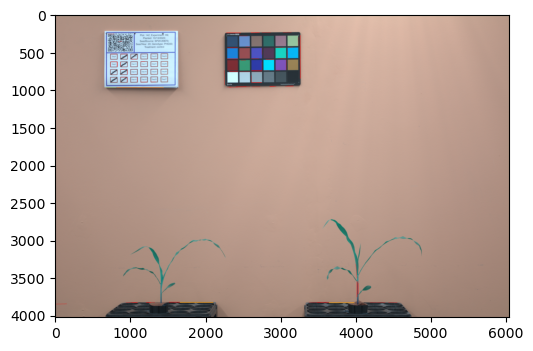

In [56]:
plt.imshow(tmp)


In [11]:
def analyze_bound_horizontal2(img, obj, mask, line_position, filename=False):

        ori_img = np.copy(img)

        # Draw line horizontal line through bottom of image, that is adjusted to user input height
        if len(np.shape(ori_img)) == 3:
            iy, ix, iz = np.shape(ori_img)
        else:
            iy, ix = np.shape(ori_img)
        size = (iy, ix)
        size1 = (iy, ix, 3)
        background = np.zeros(size, dtype=np.uint8)
        wback = np.zeros(size1, dtype=np.uint8)
        x_coor = int(ix)
        y_coor = int(iy) - int(line_position)
        rec_corner = int(iy - 2)
        rec_point1 = (1, rec_corner)
        rec_point2 = (x_coor - 2, y_coor - 2)
        cv2.rectangle(background, rec_point1, rec_point2, (255), 1)
        below_contour, below_hierarchy = cv2.findContours(background, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[-2:]

        below = []
        above = []
        mask_nonzerox, mask_nonzeroy = np.nonzero(mask)
        obj_points = np.vstack((mask_nonzeroy, mask_nonzerox))
        obj_points1 = np.transpose(obj_points)



        for i, c in enumerate(obj_points1):
                xy = tuple(c)
                pptest = cv2.pointPolygonTest(below_contour[0], xy, measureDist=False)
                if pptest == 1:
                    below.append(xy)
                    cv2.circle(ori_img, xy, 1, (0, 0, 255))
                    cv2.circle(wback, xy, 1, (0, 0, 0))
                else:
                    above.append(xy)
                    cv2.circle(ori_img, xy, 1, (0, 255, 0))
                    cv2.circle(wback, xy, 1, (255, 255, 255))
    
        return wback
ori_img = np.copy(img)
np.shape(ori_img)

# Draw line horizontal line through bottom of image, that is adjusted to user input height
# pcv.params.debug = "plot"

# June 07 2022, altered the code here so that if wback and obj were not defined by the contours that means there is no plant and is skipped instead of
# giving an error code. made sure to add an else and next statement to each if statement so pipeline would continue without presence of all plants.

if len(np.shape(ori_img)) == 3:
    iy, ix, iz = np.shape(ori_img)
else:
    iy, ix = np.shape(ori_img)

# if obj_r is not None:
#     wback_r = analyze_bound_horizontal2(img, obj_r, mask_r, iy-y_right)
if obj_m is not None:
    wback_m = analyze_bound_horizontal2(img, obj_m, mask_m, iy-y_mid)
if obj_l is not None:
    wback_l = analyze_bound_horizontal2(img, obj_l, mask_l, iy-y_left)

threshold_light = pcv.threshold.binary(img, 1, 1, 'light')



# if obj_r is not None:
#     fgmask_r = pcv.background_subtraction(wback_r, threshold_light)
# else:
#     next
if obj_m is not None:
    fgmask_m = pcv.background_subtraction(wback_m, threshold_light)
else:
    next
if obj_l is not None:
    fgmask_l = pcv.background_subtraction(wback_l, threshold_light)
else:
    next
if obj_l is not None:
    id_objects_left, obj_hierarchy_left = pcv.find_objects(img, fgmask_l)
else:
    next
if obj_m is not None:
    id_objects_mid, obj_hierarchy_mid = pcv.find_objects(img, fgmask_m)
else:
    next
# if obj_r is not None:
#     id_objects_right, obj_hierarchy_right = pcv.find_objects(img, fgmask_r)
# else:
#     next

# Combine objects
# if obj_r is not None:
#     obj_r2, mask_r2 = pcv.object_composition(img, id_objects_right, obj_hierarchy_right)
# else:
#     obj_r = None
#     next
if obj_m is not None:
    obj_m2, mask_m2 = pcv.object_composition(img, id_objects_mid, obj_hierarchy_mid)
else:
    next
if obj_l is not None:
    obj_l2, mask_l2 = pcv.object_composition(img, id_objects_left, obj_hierarchy_left)
else:
    next
if obj_m is not None:
    fgmask_m = pcv.background_subtraction(wback_m, threshold_light)
else:
    next
if obj_l is not None:
    fgmask_l = pcv.background_subtraction(wback_l, threshold_light)
else:
    next
    #plt.imshow(fgmask_l)

if obj_l is not None:
    id_objects_left, obj_hierarchy_left = pcv.find_objects(img, fgmask_l)
else:
    next
if obj_m is not None:
    id_objects_mid, obj_hierarchy_mid = pcv.find_objects(img, fgmask_m)
else:
    next
# if obj_r is not None:
#     id_objects_right, obj_hierarchy_right = pcv.find_objects(img, fgmask_r)
# else:
#     next

# Combine objects
# if obj_r is not None:
#     obj_r2, mask_r2 = pcv.object_composition(img, id_objects_right, obj_hierarchy_right)
# else:
#     obj_r2 = None
#     next
if obj_m is not None:
    obj_m2, mask_m2 = pcv.object_composition(img, id_objects_mid, obj_hierarchy_mid)
else:
    obj_m2 = None
    next
if obj_l is not None:
    obj_l2, mask_l2 = pcv.object_composition(img, id_objects_left, obj_hierarchy_left)
else:
    obj_r2 = obj_m2
    next
    
# #If right plant present
# if obj_m is not None:
#     if obj_m2 is not None:
#     #shape_img_right = pcv.analyze_object(img, obj_r2, fgmask_r) - plantCV version 3.10 code
# #         shape_img_right = pcv.analyze_object(img, obj_m2, fgmask_m, label="mid")
# #         shape_data_right = pcv.outputs.observations['mid']
# #         print("we good")
# # else:
# #     print("obj_m is Nonetype!")
# #     next



NameError: name 'obj_m' is not defined

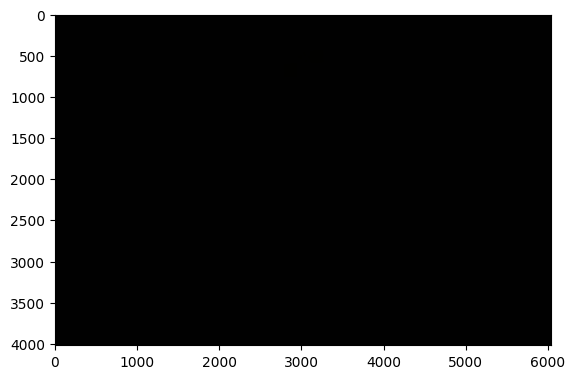

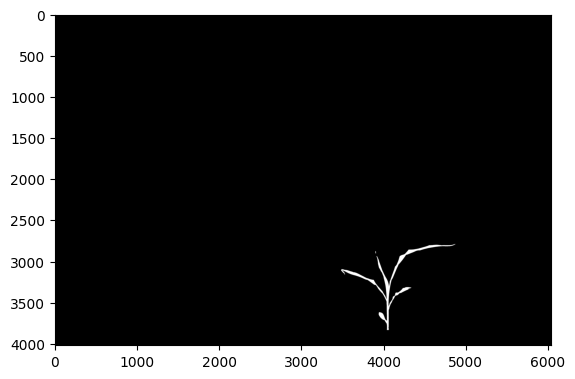

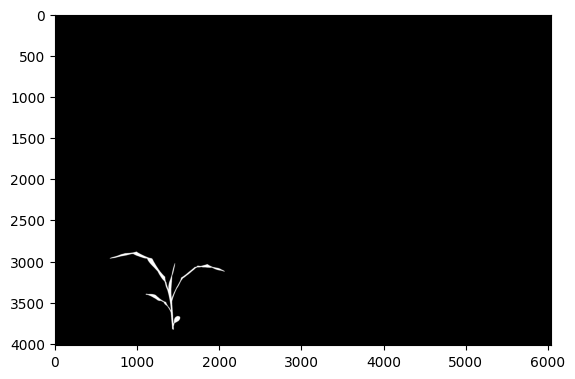

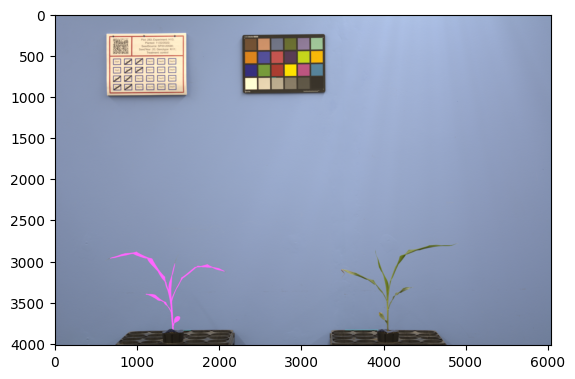

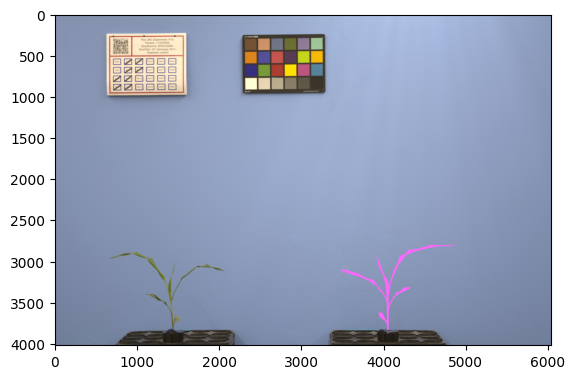

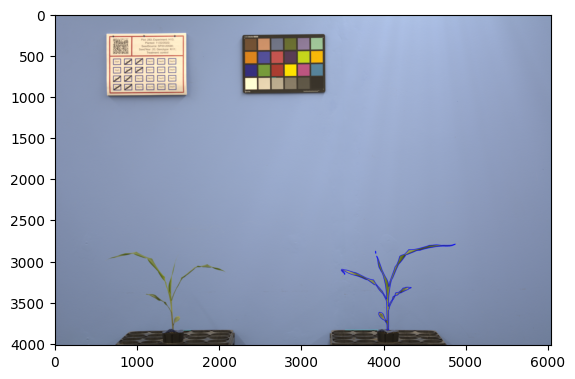

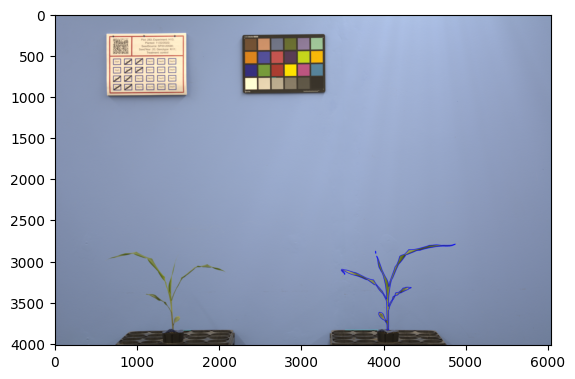

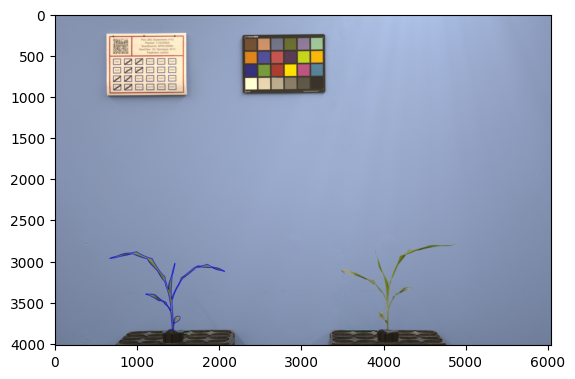

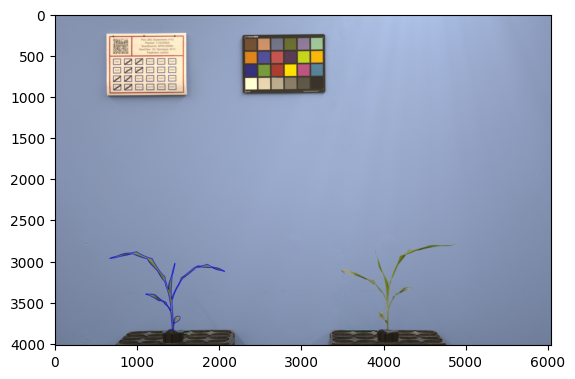

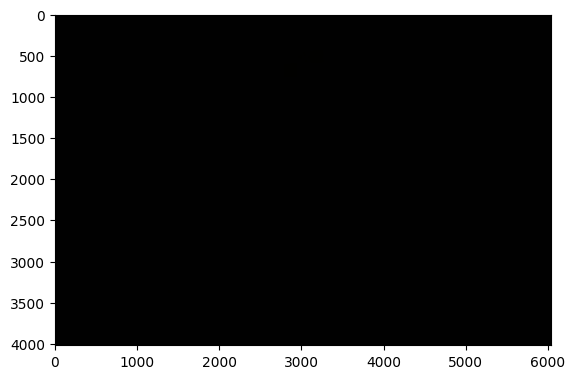

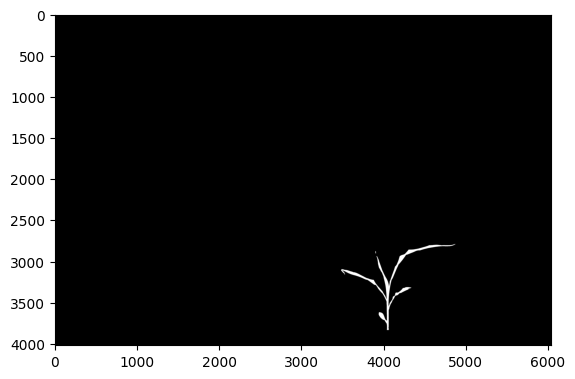

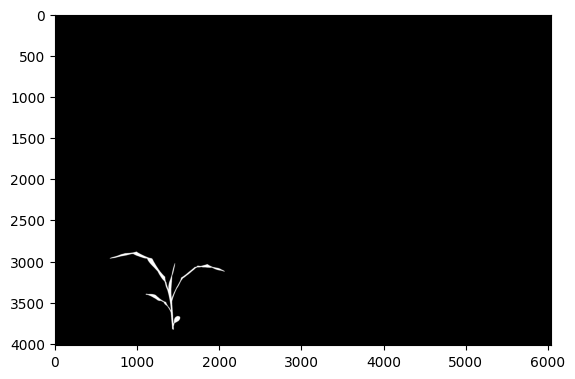

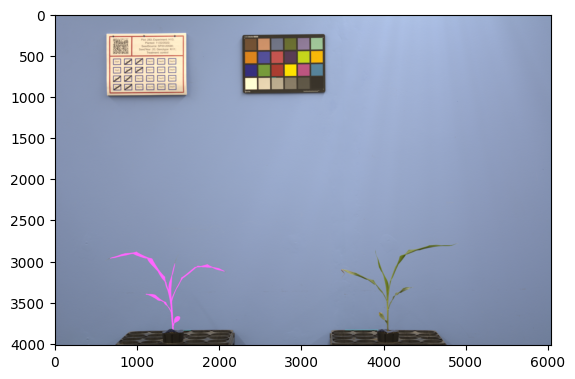

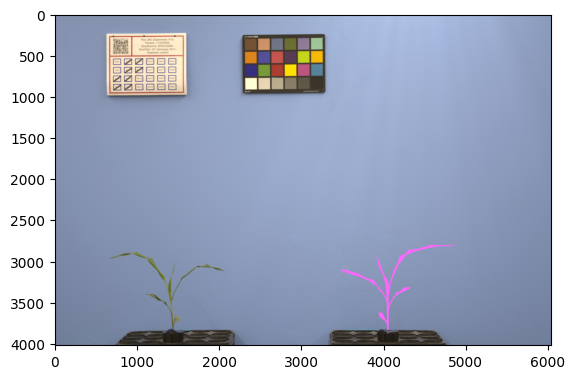

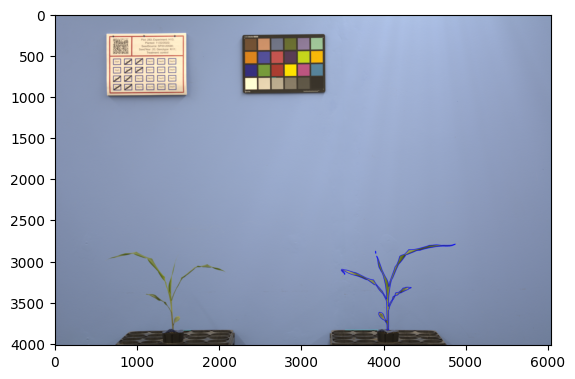

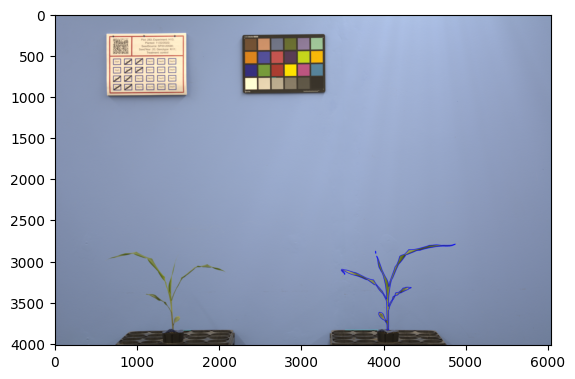

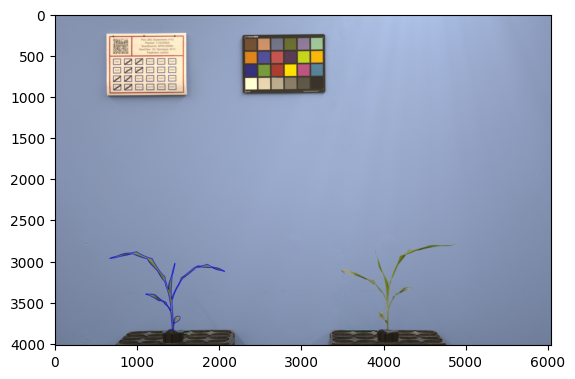

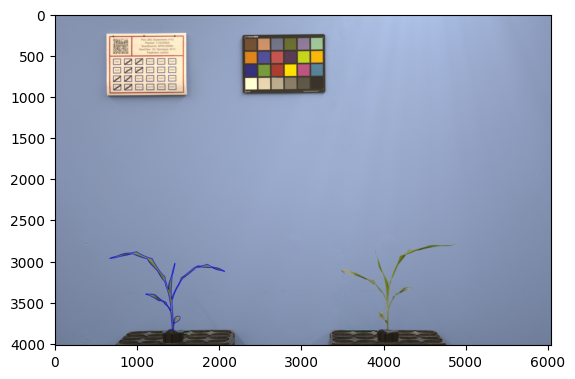

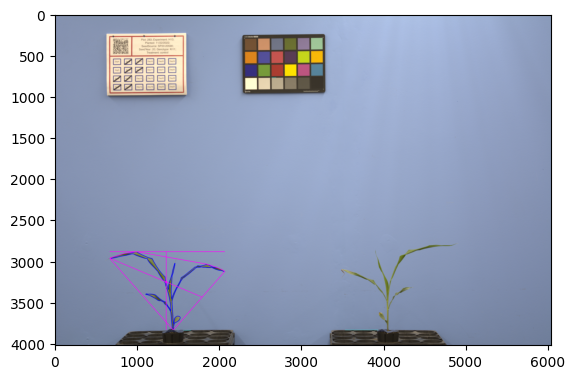

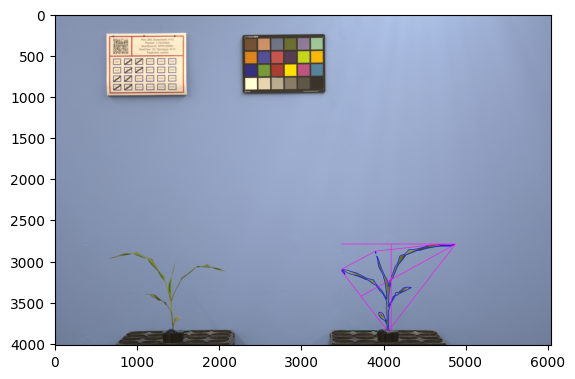

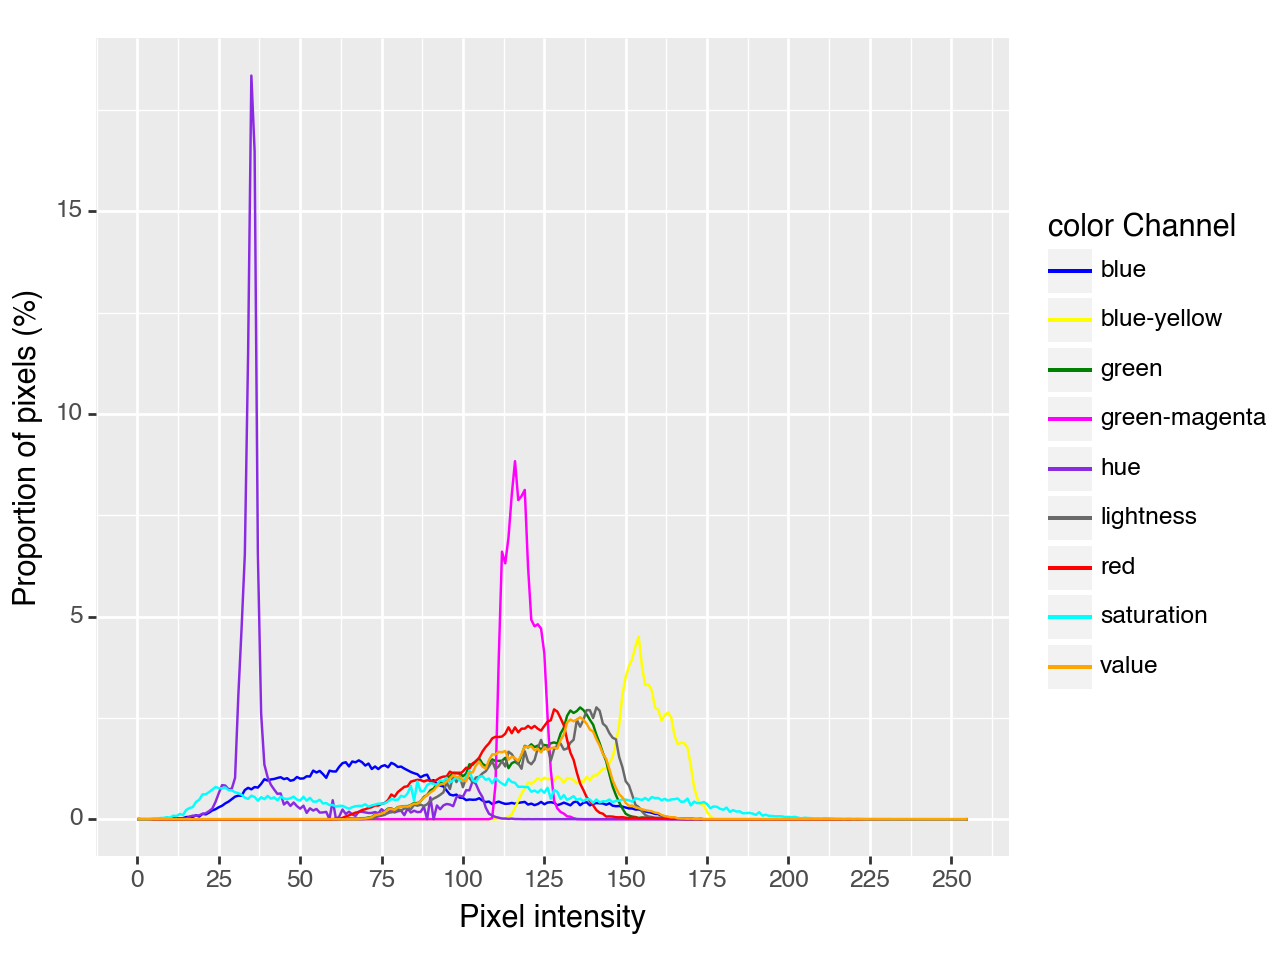


blue_frequencies= [0.0070380901438585625, 0.002815236057543425, 0.002815236057543425, 0.0014076180287717125, 0.0014076180287717125, 0.0014076180287717125, 0.00563047211508685, 0.00563047211508685, 0.002815236057543425, 0.0070380901438585625, 0.008445708172630274, 0.01689141634526055, 0.0225218884603474, 0.02111427043157569, 0.02674474254666254, 0.05348948509332508, 0.05771233917964021, 0.0563047211508685, 0.09712564398524817, 0.0675656653810422, 0.13372371273331268, 0.11964753244559556, 0.16328369133751866, 0.21677317643084373, 0.24774077306382142, 0.29559978604205966, 0.33219785479012415, 0.3913178119985361, 0.4349539708904592, 0.49548154612764284, 0.5574167393935981, 0.5813462458827172, 0.5799386278539456, 0.7207004307311168, 0.7741899158244419, 0.7375918470763774, 0.7938965682272459, 0.7812280059683004, 0.87131555980969, 0.9867402381689705, 0.9557726415359927, 0.9825173840826553, 0.993778328312829, 1.0177078348019482, 1.0374144872047522, 0.9895554742265139, 1.012077362686861, 0.950

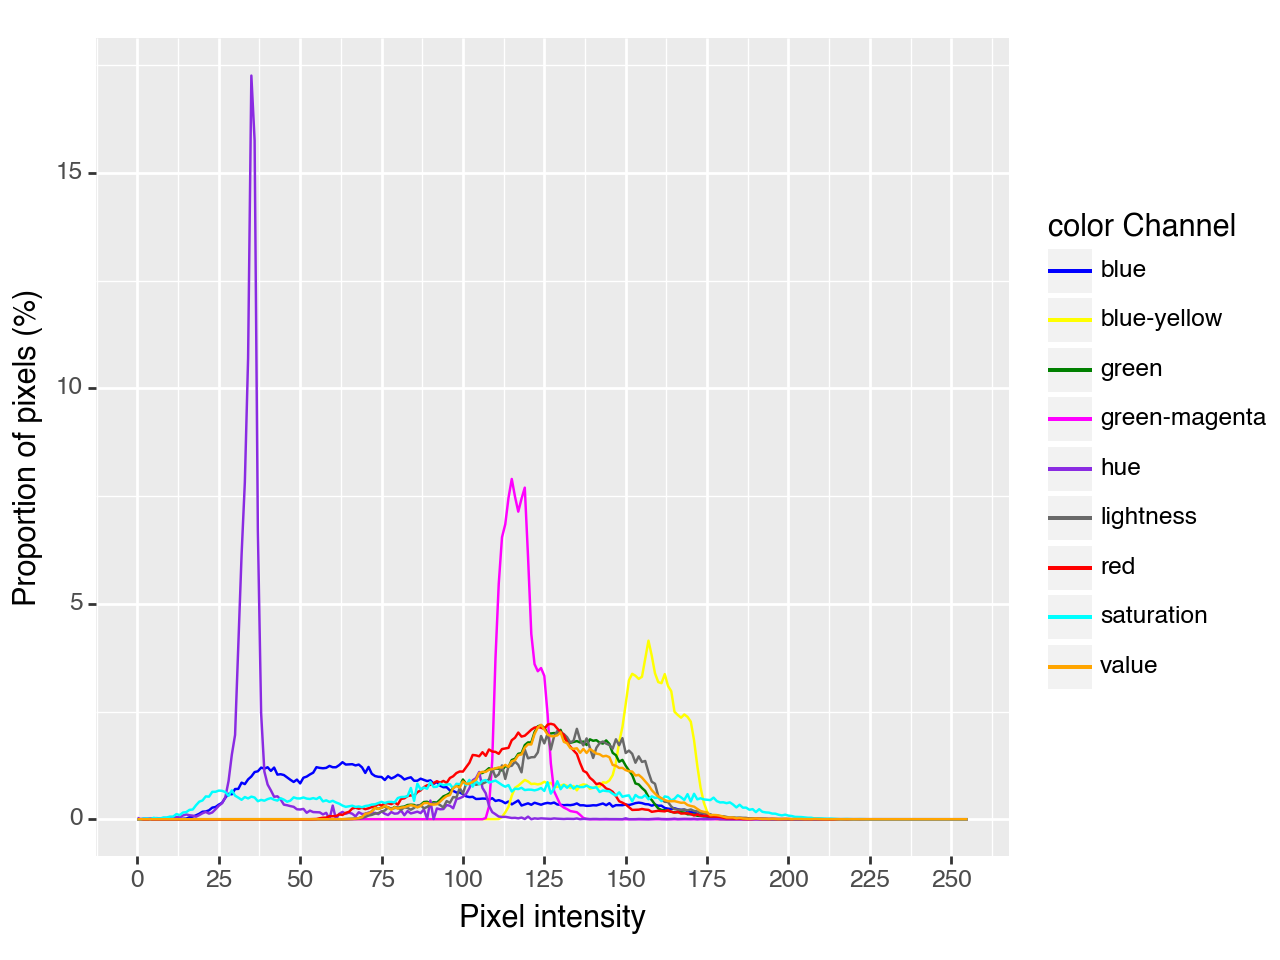

In [9]:
ori_img = np.copy(img)
np.shape(ori_img)

# Draw line horizontal line through bottom of image, that is adjusted to user input height
# pcv.params.debug = "plot"

# June 07 2022, altered the code here so that if wback and obj were not defined by the contours that means there is no plant and is skipped instead of
# giving an error code. made sure to add an else and next statement to each if statement so pipeline would continue without presence of all plants.

if len(np.shape(ori_img)) == 3:
    iy, ix, iz = np.shape(ori_img)
else:
    iy, ix = np.shape(ori_img)

# if obj_r is not None:
#     wback_r = analyze_bound_horizontal2(img, obj_r, mask_r, iy-y_right)
if obj_m is not None:
    wback_m = analyze_bound_horizontal2(img, obj_m, mask_m, iy-y_mid)
if obj_l is not None:
    wback_l = analyze_bound_horizontal2(img, obj_l, mask_l, iy-y_left)

threshold_light = pcv.threshold.binary(img, 1, 1, 'light')


# if obj_r is not None:
#     fgmask_r = pcv.background_subtraction(wback_r, threshold_light)
if obj_m is not None:
    
    fgmask_m = pcv.background_subtraction(wback_m, threshold_light)
if obj_l is not None:
    fgmask_l = pcv.background_subtraction(wback_l, threshold_light)
    #plt.imshow(fgmask_l)

if obj_l is not None:
    id_objects_left, obj_hierarchy_left = pcv.find_objects(img, fgmask_l)
if obj_m is not None:
    id_objects_mid, obj_hierarchy_mid = pcv.find_objects(img, fgmask_m)
# if obj_r is not None:
#     id_objects_right, obj_hierarchy_right = pcv.find_objects(img, fgmask_r)

# Combine objects
# if obj_r is not None:
#     obj_r2, mask_r2 = pcv.object_composition(img, id_objects_right, obj_hierarchy_right)
if obj_m is not None:
    obj_m2, mask_m2 = pcv.object_composition(img, id_objects_mid, obj_hierarchy_mid)
if obj_l is not None:
    obj_l2, mask_l2 = pcv.object_composition(img, id_objects_left, obj_hierarchy_left)
    #plt.imshow(fgmask_l)

# Draw line horizontal line through bottom of image, that is adjusted to user input height
if len(np.shape(ori_img)) == 3:
    iy, ix, iz = np.shape(ori_img)
else:
    iy, ix = np.shape(ori_img)

# if obj_r is not None:
#     wback_r = analyze_bound_horizontal2(img, obj_r, mask_r, iy-y_right)
if obj_m is not None:
    wback_m = analyze_bound_horizontal2(img, obj_m, mask_m, iy-y_mid)
if obj_l is not None:
    wback_l = analyze_bound_horizontal2(img, obj_l, mask_l, iy-y_left)

threshold_light = pcv.threshold.binary(img, 1, 1, 'light')

# if obj_r is not None:
#     fgmask_r = pcv.background_subtraction(wback_r, threshold_light)
if obj_m is not None:
    fgmask_m = pcv.background_subtraction(wback_m, threshold_light)
if obj_l is not None:
    fgmask_l = pcv.background_subtraction(wback_l, threshold_light)
    #plt.imshow(fgmask_l)

if obj_l is not None:
    id_objects_left, obj_hierarchy_left = pcv.find_objects(img, fgmask_l)
if obj_m is not None:
    id_objects_mid, obj_hierarchy_mid = pcv.find_objects(img, fgmask_m)
# if obj_r is not None:
#     id_objects_right, obj_hierarchy_right = pcv.find_objects(img, fgmask_r)

# Combine objects
# if obj_r is not None:
#     obj_r2, mask_r2 = pcv.object_composition(img, id_objects_right, obj_hierarchy_right)
if obj_m is not None:
    obj_m2, mask_m2 = pcv.object_composition(img, id_objects_mid, obj_hierarchy_mid)
if obj_l is not None:
    obj_l2, mask_l2 = pcv.object_composition(img, id_objects_left, obj_hierarchy_left)
    #plt.imshow(fgmask_l)



## morphological and color trait measurements
# Shape measurements
    # Shape data stored:
    # 'area'
    # 'convex_hull_area'
    # 'solidity'
    # 'perimeter'
    # 'width'
    # 'height'
    # 'longest_path'
    # 'center_of_mass'
    # 'convex_hull_vertices'
    # 'object_in_frame'
    # 'ellipse_center'
    # 'ellipse_major_axis'
    # 'ellipse_minor_axis'
    # 'ellipse_angle'
    # 'ellipse_eccentricity'

#pcv.params.debug = "plot"
#If left plant present
#June 07 2022 have to add second if statement for obj_*2 because this variable is not defined and will error if plant is missing with an if- else statement 
# If left plant present
if obj_l is not None:
    #shape_img_left = pcv.analyze_object(img, obj_l2, fgmask_l) - plantCV version 3.10 code
    shape_img_left = pcv.analyze_object(img, obj_l2, fgmask_l, label="left")
    shape_data_left = pcv.outputs.observations['left']

    
   
if obj_m is not None:
    #shape_img_mid = pcv.analyze_object(img, obj_m2, fgmask_m) - plantCV version 3.10 code
    shape_img_mid = pcv.analyze_object(img, obj_m2, fgmask_m, label="mid")
    shape_data_mid = pcv.outputs.observations['mid']


# If left plant is present
if obj_l is not None:
    # Process the color data for the left plant
    All_color_data_left = pcv.analyze_color(rgb_img=img, mask=fgmask_l, colorspaces='all', label="left")
    color_data_left = pcv.outputs.observations['left']

    # Print or store color data
    # e.g., Access specific values:
    print("blue_frequencies=", color_data_left.get("blue_frequencies", {}).get("value", None))
    print("green_frequencies=", color_data_left.get("green_frequencies", {}).get("value", None))

# If middle plant is present
if obj_m is not None:
    # Process the color data for the middle plant
    All_color_data_mid = pcv.analyze_color(rgb_img=img, mask=fgmask_m, colorspaces='all', label="mid")
    color_data_mid = pcv.outputs.observations['mid']


In [ ]:
#pcv.params.debug = "plot"
#If left plant present
#June 07 2022 have to add second if statement for obj_*2 because this variable is not defined and will error if plant is missing with an if- else statement 
# If left plant present
if obj_l is not None:
    #shape_img_left = pcv.analyze_object(img, obj_l2, fgmask_l) - plantCV version 3.10 code
    shape_img_left = pcv.analyze_object(img, obj_l2, fgmask_l, label="left")
    shape_data_left = pcv.outputs.observations['left']

    
   
if obj_m is not None:
    #shape_img_mid = pcv.analyze_object(img, obj_m2, fgmask_m) - plantCV version 3.10 code
    shape_img_mid = pcv.analyze_object(img, obj_m2, fgmask_m, label="mid")
    shape_data_mid = pcv.outputs.observations['mid']

#pcv.params.debug = "plot"
# If left plant present
if obj_l is not None:
        #All_color_data_left = pcv.analyze_color(rgb_img=img, mask=fgmask_l, hist_plot_type='all') - plantCV version 3.10 code
        #color_data_left = pcv.outputs.observations - plantCV version 3.10 code
    All_color_data_left = pcv.analyze_color(rgb_img=img, mask=fgmask_l, hist_plot_type='all', label="left")
    color_data_left = pcv.outputs.observations['left']

    

# If middle plant is present
if obj_m is not None:
        #All_color_data_mid = pcv.analyze_color(rgb_img=img, mask=fgmask_m, hist_plot_type='all') - plantCV version 3.10 code
        #color_data_mid = pcv.outputs.observations - plantCV version 3.10 code
    All_color_data_mid = pcv.analyze_color(rgb_img=img, mask=fgmask_m, hist_plot_type='all', label="mid")
    color_data_mid = pcv.outputs.observations['mid']




In [8]:
# pcv.params.debug = "plot"
# If left plant present
# June 07 2022 - Added second if statement for obj_*2 because this variable is not defined and will error if the plant is missing with an if-else statement 

if obj_l is not None:
    if obj_l2 is not None:
        # Analyze shape of left plant
        shape_img_left = pcv.analyze_object(img, obj_l2, fgmask_l, label="left")
        shape_data_left = pcv.outputs.observations['left']

if obj_m is not None:
    if obj_m2 is not None:
        # Analyze shape of middle plant
        shape_img_mid = pcv.analyze_object(img, obj_m2, fgmask_m, label="mid")
        shape_data_mid = pcv.outputs.observations['mid']

# If left plant present
if obj_l is not None:
    if obj_l2 is not None:
        # Analyze color of left plant using colorspaces instead of hist_plot_type
        All_color_data_left = pcv.analyze_color(rgb_img=img, mask=fgmask_l, colorspaces='all', label="left")
        color_data_left = pcv.outputs.observations['left']

# If middle plant is present
if obj_m is not None:
    if obj_m2 is not None:
        # Analyze color of middle plant using colorspaces instead of hist_plot_type
        All_color_data_mid = pcv.analyze_color(rgb_img=img, mask=fgmask_m, colorspaces='all', label="mid")
        color_data_mid = pcv.outputs.observations['mid']


NameError: name 'obj_l' is not defined

In [9]:
new_header = ['experiment', 'day', 'genotype', 'treatment', 'plot', 'plant', 'percent.necrosis', 'area', 'convex_hull_area', 'solidity', 'perimeter', 'width', 'height', 'longest_path', 'center_of_mass', 'convex_hull_vertices', 'in_frame', 'ellipse_center', 'ellipse_major_axis', 'ellipse_minor_axis', 'ellipse_angle', 'ellipse_eccentricity', 'bin_number', 'bin_values', 'blue_frequencies', 'green_frequencies', 'red_frequencies', 'lightness_frequencies', 'green-magenta_frequencies', 'blue-yellow_frequencies', 'hue_Frequencies', 'saturation_frequencies', 'value_frequencies', 'hue_circular_mean', 'hue_circular_std', 'hue_median']

# Add header to table to contain trait information for all plants
table = []
table.append(new_header)
#print(table)

# Add healthy and stem masks together to be able to generate the percent necrosis
added2 = masks["healthy"] + masks["stem"]

# Calculate necrosis and combine trait information from all kept objects (plants)
# If left plant present
# June 07 2022 If obj_*2 is present
if obj_l is not None:
    if obj_l2 is not None:
        masked_image_healthy_left = pcv.apply_mask(added2, fgmask_l, 'black')
        masked_image_necrosis_left = pcv.apply_mask(masks["necrosis"], fgmask_l, 'black')
        added_obj_left = masked_image_healthy_left + masked_image_necrosis_left
        sample = "A"
    
    # Necrosis calculations
    # Possible reason Ph207 wont work
        necrosis_left = np.sum(masked_image_necrosis_left)
        necrosis_percent_left = float(necrosis_left)/np.sum(added_obj_left)

        # Add trait data for left plant to trait table in proper order
        table.append([exp_name, day, geno_name, treat_name, plot, sample, round(necrosis_percent_left, 5), shape_data_left['area']['value'], shape_data_left['convex_hull_area']['value'], shape_data_left['solidity']['value'], shape_data_left['perimeter']['value'], shape_data_left['width']['value'], shape_data_left['height']['value'], shape_data_left['longest_path']['value'], shape_data_left['center_of_mass']['value'], shape_data_left['convex_hull_vertices']['value'], shape_data_left['object_in_frame']['value'], shape_data_left['ellipse_center']['value'], shape_data_left['ellipse_major_axis']['value'], shape_data_left['ellipse_minor_axis']['value'], shape_data_left['ellipse_angle']['value'], shape_data_left['ellipse_eccentricity']['value'], '"{}"'.format(color_data_left['blue_frequencies']['value']), '"{}"'.format(color_data_left['green_frequencies']['value']), '"{}"'.format(color_data_left['red_frequencies']['value']), '"{}"'.format(color_data_left['lightness_frequencies']['value']), '"{}"'.format(color_data_left['green-magenta_frequencies']['value']), '"{}"'.format(color_data_left['blue-yellow_frequencies']['value']), '"{}"'.format(color_data_left['hue_frequencies']['value']), '"{}"'.format(color_data_left['saturation_frequencies']['value']), '"{}"'.format(color_data_left['value_frequencies']['value']), '"{}"'.format(color_data_left['hue_circular_mean']['value']), '"{}"'.format(color_data_left['hue_circular_std']['value']), '"{}"'.format(color_data_left['hue_median']['value'])])
        #print(table)
    
    else:
        print("No Left Plant")
        next
# If middle plant present
if obj_m is not None:
    if obj_m2 is not None:
        masked_image_healthy_mid = pcv.apply_mask(added2, fgmask_m, 'black')
        masked_image_necrosis_mid = pcv.apply_mask(masks["necrosis"], fgmask_m, 'black')
        added_obj_mid = masked_image_healthy_mid + masked_image_necrosis_mid
        sample = "B"

        # Necrosis calculations
        necrosis_mid = np.sum(masked_image_necrosis_mid)
        necrosis_percent_mid = float(necrosis_mid)/np.sum(added_obj_mid)

        # Add trait data for middle plant to trait table in proper order
        table.append([exp_name, day, geno_name, treat_name, plot, sample, round(necrosis_percent_mid, 5), shape_data_mid['area']['value'], shape_data_mid['convex_hull_area']['value'], shape_data_mid['solidity']['value'], shape_data_mid['perimeter']['value'], shape_data_mid['width']['value'], shape_data_mid['height']['value'], shape_data_mid['longest_path']['value'], shape_data_mid['center_of_mass']['value'], shape_data_mid['convex_hull_vertices']['value'], shape_data_mid['object_in_frame']['value'], shape_data_mid['ellipse_center']['value'], shape_data_mid['ellipse_major_axis']['value'], shape_data_mid['ellipse_minor_axis']['value'], shape_data_mid['ellipse_angle']['value'], shape_data_mid['ellipse_eccentricity']['value'], '"{}"'.format(color_data_mid['blue_frequencies']['value']), '"{}"'.format(color_data_mid['green_frequencies']['value']), '"{}"'.format(color_data_mid['red_frequencies']['value']), '"{}"'.format(color_data_mid['lightness_frequencies']['value']), '"{}"'.format(color_data_mid['green-magenta_frequencies']['value']), '"{}"'.format(color_data_mid['blue-yellow_frequencies']['value']), '"{}"'.format(color_data_mid['hue_frequencies']['value']), '"{}"'.format(color_data_mid['saturation_frequencies']['value']), '"{}"'.format(color_data_mid['value_frequencies']['value']), '"{}"'.format(color_data_mid['hue_circular_mean']['value']), '"{}"'.format(color_data_mid['hue_circular_std']['value']), '"{}"'.format(color_data_mid['hue_median']['value'])])
        #print(table)
    else:
        print("No Middle Plant")
        next


NameError: name 'obj_l' is not defined

In [10]:
mask_binary = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

# # If right plant present
# if obj_r is not None:
#     if obj_r2 is not None:
#     #shape_img_right = pcv.analyze_object(img, obj_r2, fgmask_r) - plantCV version 3.10 code
#         shape_img_right = pcv.analyze_object(img, obj_r2, fgmask_r, label="right")
#         shape_data_right = pcv.outputs.observations['right']
#         print("we good")
# else:
#     print("obj_r is Nonetype!")
#     next

## morphological and color trait measurements
# Shape measurements
    # Shape data stored:
    # 'area'
    # 'convex_hull_area'
    # 'solidity'
    # 'perimeter'
    # 'width'
    # 'height'
    # 'longest_path'
    # 'center_of_mass'
    # 'convex_hull_vertices'
    # 'object_in_frame'
    # 'ellipse_center'
    # 'ellipse_major_axis'
    # 'ellipse_minor_axis'
    # 'ellipse_angle'
    # 'ellipse_eccentricity'

if obj_l is not None:
    if obj_l2 is not None:
     #shape_img_left = pcv.analyze_object(img, obj_l2, fgmask_l) - plantCV version 3.10 code
        shape_img_left = pcv.analyze_object(img, obj_l2, fgmask_l, label="left")
        skel = pcv.morphology.skeletonize(mask=mask)
        shape_data_left = pcv.outputs.observations['left']
    else:
        print("obj_l is Nonetype")
        next
#print(shape_img_left)
    #print(shape_data_left['area']['value'])
    #print("area =",shape_data_left['area']['value'])
    # print("convex hull area =", shape_data_left['convex_hull_area']['value'])
    # print("solidity =", shape_data_left['solidity']['value'])
    # print("perimeter =", shape_data_left['perimeter']['value'])
    # print("width =", shape_data_left['width']['value'])
    #print("height =", shape_data_left['height']['value'])
    # print("longest_path =", shape_data_left['longest_path']['value'])
    # print("center_of_mass =", shape_data_left['center_of_mass']['value'])
    # print("convex_hull_vertices =", shape_data_left['convex_hull_vertices']['value'])
    # print("object_in_frame =", shape_data_left['object_in_frame']['value'])
    # print("ellipse_center =", shape_data_left['ellipse_center']['value'])
    # print("ellipse_major_axis =", shape_data_left['ellipse_major_axis']['value'])
    # print("ellipse_minor_axis =", shape_data_left['ellipse_minor_axis']['value'])
    # print("ellipse_angle =", shape_data_left['ellipse_angle']['value'])
    # print("ellipse_eccentricity =", shape_data_left['ellipse_eccentricity']['value'])

# If middle plant present

if obj_m is not None:
    if obj_m2 is not None:           
#     #shape_img_mid = pcv.analyze_object(img, obj_m2, fgmask_m) - plantCV version 3.10 code
        shape_img_mid = pcv.analyze_object(img, obj_m2, fgmask_m, label="mid")
        skel = pcv.morphology.skeletonize(mask=mask)
        shape_data_mid = pcv.outputs.observations['mid']
    else:
        print("obj_m is None!")
        next

    #print("area =", shape_data_mid['area']['value'])
    # print("convex hull area =", shape_data_mid['convex_hull_area']['value'])
    # print("solidity =",shape_data_mid['solidity']['value'])
    # print("perimeter =",shape_data_mid['perimeter']['value'])
    # print("width=", shape_data_mid['width']['value'])
    # print("height =", shape_data_mid['height']['value'])
    # print("longest_path =", shape_data_mid['longest_path']['value'])
    # print("center_of_mass =", shape_data_mid['center_of_mass']['value'])
    # print("convex_hull_vertices =", shape_data_mid['convex_hull_vertices']['value'])
    # print("object_in_frame =", shape_data_mid['object_in_frame']['value'])
    # print("ellipse_center =", shape_data_mid['ellipse_center']['value'])
    # print("ellipse_major_axis =", shape_data_mid['ellipse_major_axis']['value'])
    # print("ellipse_minor_axis =", shape_data_mid['ellipse_minor_axis']['value'])
    # print("ellipse_angle =", shape_data_mid['ellipse_angle']['value'])
    # print("ellipse_eccentricity =", shape_data_mid['ellipse_eccentricity']['value'])



    # print("area =", shape_data_right['area']['value'])
    # print("convex hull area =", shape_data_right['convex_hull_area']['value'])
    # print("solidity=",shape_data_right['solidity']['value'])
    # print("perimeter=",shape_data_right['perimeter']['value'])
    # print("width=", shape_data_right['width']['value'])
    # print("height=", shape_data_right['height']['value'])
    # print("longest_path=", shape_data_right['longest_path']['value'])
    # print("center_of_mass=", shape_data_right['center_of_mass']['value'])
    # print("convex_hull_vertices=", shape_data_right['convex_hull_vertices']['value'])
    # print("object_in_frame=", shape_data_right['object_in_frame']['value'])
    # print("ellipse_center=", shape_data_right['ellipse_center']['value'])
    # print("ellipse_major_axis=", shape_data_right['ellipse_major_axis']['value'])
    # print("ellipse_minor_axis=", shape_data_right['ellipse_minor_axis']['value'])
    # print("ellipse_angle=", shape_data_right['ellipse_angle']['value'])
    # print("ellipse_eccentricity=", shape_data_right['ellipse_eccentricity']['value'])

NameError: name 'mask' is not defined

In [22]:
np.unique(mask)

array([  0, 255], dtype=uint8)

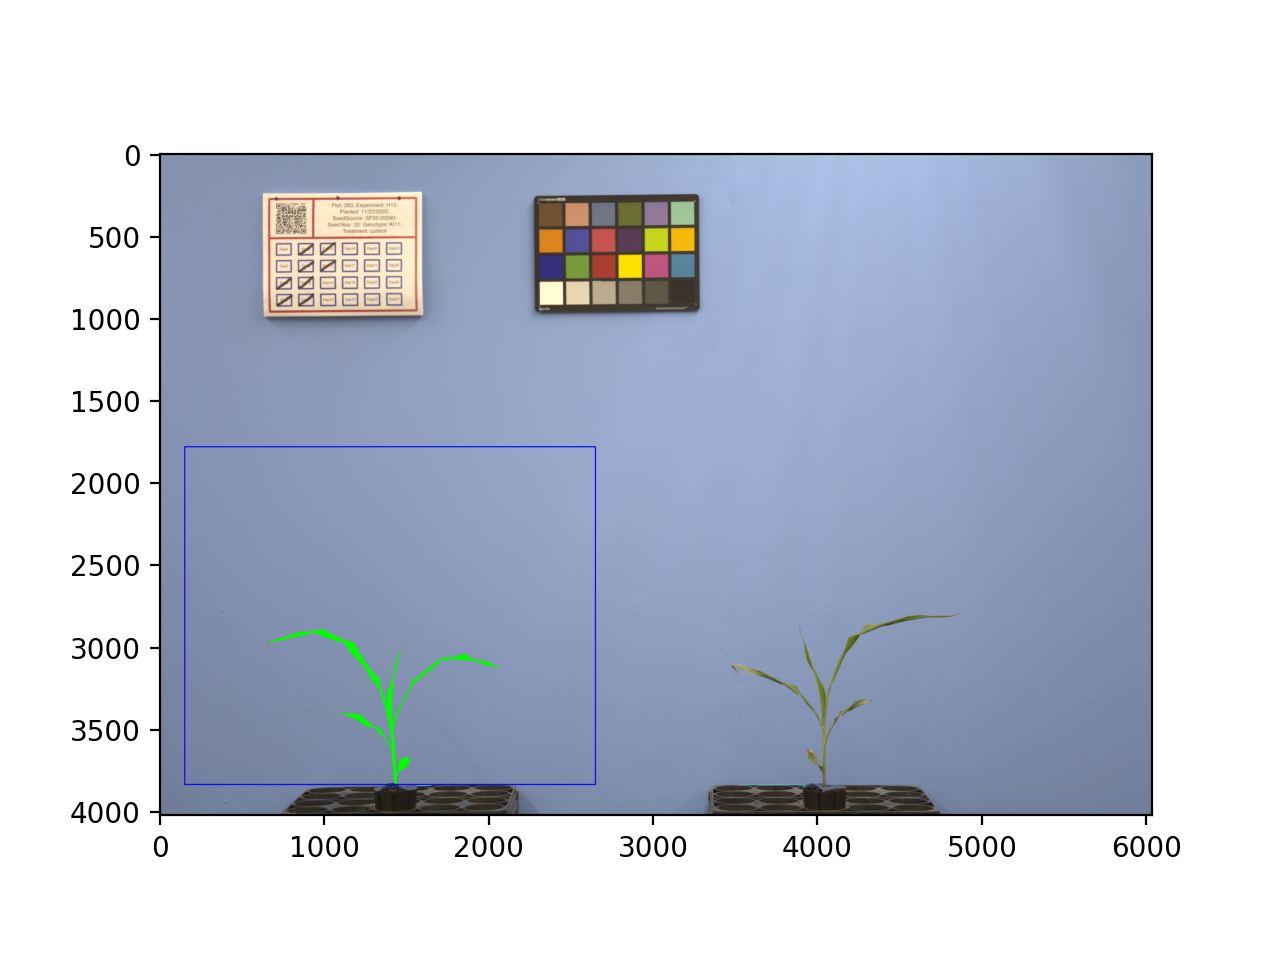

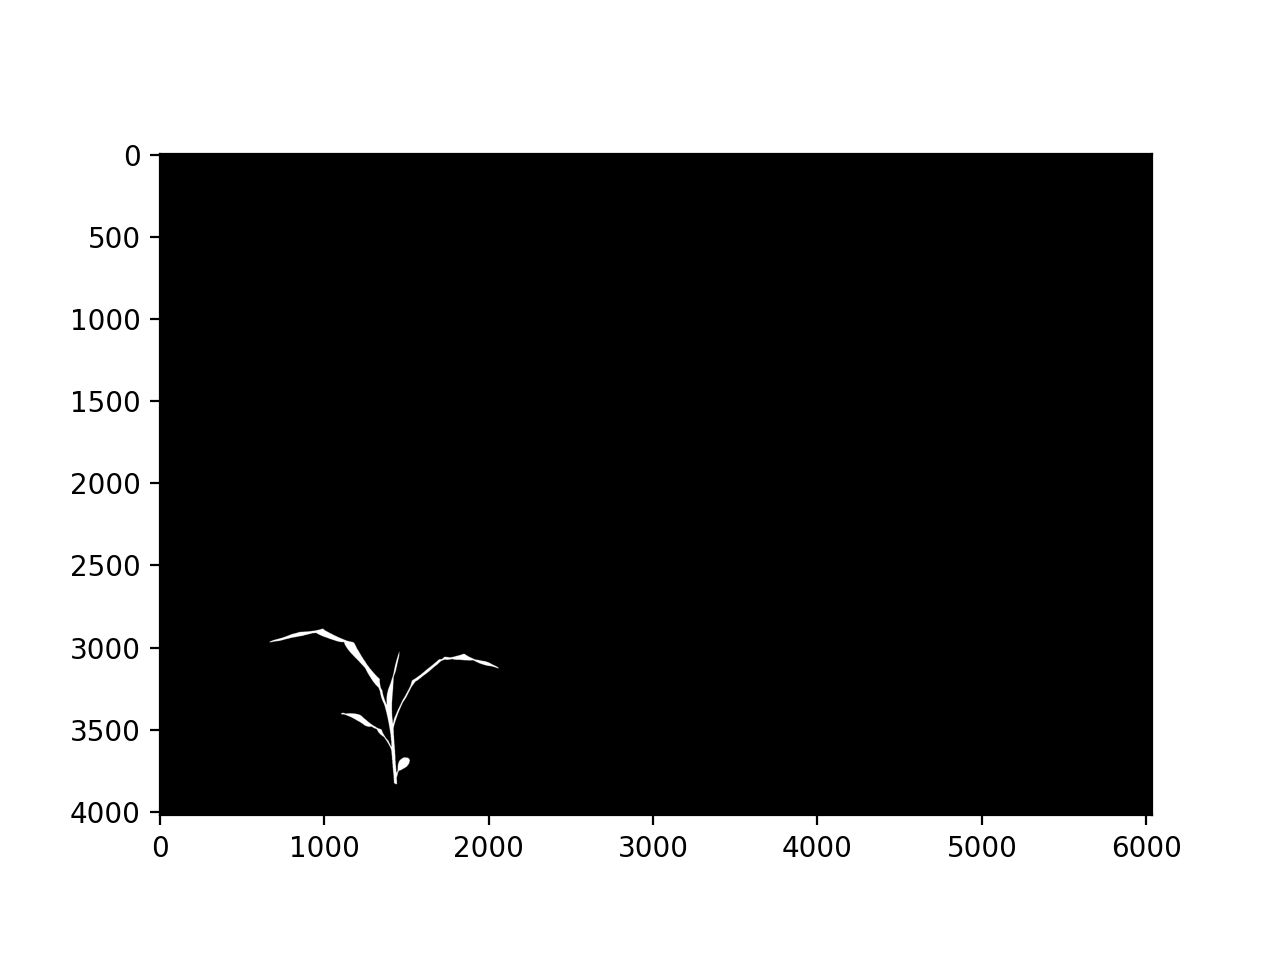

([array([[[1454, 3028]],
  
         [[1454, 3029]],
  
         [[1454, 3030]],
  
         [[1454, 3031]],
  
         [[1454, 3032]],
  
         [[1455, 3032]],
  
         [[1456, 3032]],
  
         [[1457, 3032]],
  
         [[1457, 3031]],
  
         [[1457, 3030]],
  
         [[1457, 3029]],
  
         [[1457, 3028]],
  
         [[1456, 3028]],
  
         [[1455, 3028]]], dtype=int32),
  array([[[ 987, 2887]],
  
         [[ 986, 2888]],
  
         [[ 985, 2888]],
  
         ...,
  
         [[ 990, 2887]],
  
         [[ 989, 2887]],
  
         [[ 988, 2887]]], dtype=int32)],
 array([[[ 1, -1, -1, -1],
         [-1,  0, -1, -1]]], dtype=int32),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 65162)

In [13]:
pcv.roi_objects(img,roi_left, roi_hierarchy_left,id_objects, obj_hierarchy,'partial')

In [20]:
import cv2
import plantcv as pcv
from plantcv.transform.color_correction import find_color_card

# Load the image correctly
rgb_img = cv2.imread("/Users/propst/Desktop/kp_maize_project_folders/project_folder/H13/H13_nef/05-Dec-2022/{Plot_283}{Experiment_H13}{Planted_11-28-2022}{SeedSource_SP20_20590}{SeedYear_20}{Genotype_Ki11}{Treatment_control}{PictureDay_13}.tiff")

# Ensure the image is read correctly
if rgb_img is None:
    print("Error loading image!")
else:
    # Proceed with finding the color card
    find_color_card(rgb_img, threshold_type='adaptgauss', threshvalue=125, blurry=False, background='dark', record_chip_size='median', label="default")


ModuleNotFoundError: No module named 'plantcv.transform'

In [ ]:
# Color data
    # Color data stored:
    # 'blue_frequencies'
    # 'green_frequencies'
    # 'red_frequencies'
    # 'lightness_frequencies'
    # 'green-magenta_frequencies'
    # 'blue-yellow_frequencies'
    # 'hue_frequencies'
    # 'saturation_frequencies'
    # 'value_frequencies'
    # 'hue_circular_mean'
    # 'hue_circular_std'
    # 'hue_median'

#pcv.params.debug = "plot"
# If left plant present
# If left plant present
if obj_l is not None:
    if obj_l2 is not None:
    #All_color_data_left = pcv.analyze_color(rgb_img=img, mask=fgmask_l, hist_plot_type='all') - plantCV version 3.10 code
    #color_data_left = pcv.outputs.observations - plantCV version 3.10 code
        All_color_data_left = pcv.analyze_color(rgb_img=img, mask=fgmask_l, hist_plot_type='all', label="left")
        color_data_left = pcv.outputs.observations['left']
    # print("blue_frequencies=", color_data_left["blue_frequencies"]["value"])
    # print("green_frequencies=", color_data_left["green_frequencies"]["value"])
    # print("red_frequencies=", color_data_left["red_frequencies"]["value"])
    # print("lightness_frequencies=", color_data_left["lightness_frequencies"]["value"])
    # print("green-magenta_frequencies=", color_data_left["green-magenta_frequencies"]["value"])
    # print("blue-yellow_frequencies=", color_data_left["blue-yellow_frequencies"]["value"])
    # print("hue_frequencies=", color_data_left["hue_frequencies"]["value"])
    # print("saturation_frequencies=", color_data_left["saturation_frequencies"]["value"])
    # print("value_frequencies=", color_data_left["value_frequencies"]["value"])
    # print("hue_circular_mean=", color_data_left["hue_circular_mean"]["value"])
    # print("hue_circular_std=", color_data_left["hue_circular_std"]["value"])
    # print("hue_median=", color_data_left["hue_median"]["value"])

# If middle plant is present
if obj_m is not None:
    if obj_m2 is not None:
#All_color_data_mid = pcv.analyze_color(rgb_img=img, mask=fgmask_m, hist_plot_type='all') - plantCV version 3.10 code
#color_data_mid = pcv.outputs.observations - plantCV version 3.10 code
        All_color_data_mid = pcv.analyze_color(rgb_img=img, mask=fgmask_m, hist_plot_type='all', label="mid")
        color_data_mid = pcv.outputs.observations['mid']

    # print("blue_frequencies=", color_data_mid["blue_frequencies"]["value"])
    # print("green_frequencies=", color_data_mid["green_frequencies"]["value"])
    # print("red_frequencies=", color_data_mid["red_frequencies"]["value"])
    # print("lightness_frequencies=", color_data_mid["lightness_frequencies"]["value"])
    # print("green-magenta_frequencies=", color_data_mid["green-magenta_frequencies"]["value"])
    # print("blue-yellow_frequencies=", color_data_mid["blue-yellow_frequencies"]["value"])
    # print("hue_frequencies=", color_data_mid["hue_frequencies"]["value"])
    # print("saturation_frequencies=", color_data_mid["saturation_frequencies"]["value"])
    # print("value_frequencies=", color_data_mid["value_frequencies"]["value"])
    # print("hue_circular_mean=", color_data_mid["hue_circular_mean"]["value"])
    # print("hue_circular_std=", color_data_mid["hue_circular_std"]["value"])
    # print("hue_median=", color_data_mid["hue_median"]["value"])

# If right plant is present
if obj_r is not None:
    if obj_r2 is not None:    
    # All_color_data_right = pcv.analyze_color(rgb_img=img, mask=fgmask_r, hist_plot_type='all') - plantCV version 3.10 code
    # color_data_right = pcv.outputs.observations - plantCV version 3.10 code
        All_color_data_right = pcv.analyze_color(rgb_img=img, mask=fgmask_r, hist_plot_type='all', label="right")
        color_data_right = pcv.outputs.observations['right']

    # print("blue_frequencies=", color_data_right["blue_frequencies"]["value"])
    # print("green_frequencies=", color_data_right["green_frequencies"]["value"])
    # print("red_frequencies=", color_data_right["red_frequencies"]["value"])
    # print("lightness_frequencies=", color_data_right["lightness_frequencies"]["value"])
    # print("green-magenta_frequencies=", color_data_right["green-magenta_frequencies"]["value"])
    # print("blue-yellow_frequencies=", color_data_right["blue-yellow_frequencies"]["value"])
    # print("hue_frequencies=", color_data_right["hue_frequencies"]["value"])
    # print("saturation_frequencies=", color_data_right["saturation_frequencies"]["value"])
    # print("value_frequencies=", color_data_right["value_frequencies"]["value"])
    # print("hue_circular_mean=", color_data_right["hue_circular_mean"]["value"])
    # print("hue_circular_std=", color_data_right["hue_circular_std"]["value"])
    # print("hue_median=", color_data_right["hue_median"]["value"])

In [ ]:
# Print output mask images
# Automatically generate file names
# If left plant present
#pcv.params.debug = "plot"
if obj_l is not None:
    merged2 = cv2.merge([masked_image_healthy_left, np.zeros(np.shape(masks["healthy"]),dtype=np.uint8), masked_image_necrosis_left]) #blue, green, red
    pcv.print_image(merged2, geno_name+'_'+plot+'_'+'A'+'_'+day+'_'+'merged.jpg')

# If middle plant present
if obj_m is not None:
    merged3 = cv2.merge([masked_image_healthy_mid, np.zeros(np.shape(masks["healthy"]),dtype=np.uint8), masked_image_necrosis_mid]) #blue, green, red
    pcv.print_image(merged3, geno_name+'_'+plot+'_'+'B'+'_'+day+'_'+'merged.jpg')

# If right plant present
if obj_r is not None:
    merged4 = cv2.merge([masked_image_healthy_right, np.zeros(np.shape(masks["healthy"]),dtype=np.uint8), masked_image_necrosis_right]) #blue, green, red
    pcv.print_image(merged4, geno_name+'_'+plot+'_'+'C'+'_'+day+'_'+'merged.jpg')

In [ ]:
 # Save all trait results to file
    # Individual tab delimited files for each image
    file_name = filename.split("}{")
    print(file_name)
    file_name = "{"+file_name[1]+"}"+file_name[0]+"}{"+file_name[5]+"}{"+file_name[7]
    outfile = str(file_name[:-4]) + 'txt'
    print(outfile)

    with open(outfile, 'w') as f:
        for row in table:
            f.write('\t'.join(map(str, row)) + '\n')

if __name__ == '__main__':
    main()